In [1]:
import pandas as pd

# 전처리 CSV 파일 불러오기 
df = pd.read_csv('wildfire_preprocessed_4_logs_target.csv')

# 데이터 첫 5행 확인
print(df.head())

   DSPT_REQ_HR  HR_UNIT_ARTMP  HR_UNIT_HUM  WSPD_BIN  MONTH  \
0          246           -1.0         39.0         1      1   
1          253            5.0         60.0         1      3   
2          643            7.0         49.0         1      3   
3          578            0.3         48.0         3      3   
4          874           -8.7         36.0         5     12   

   CMBS_EXPOBJ_LCLSF_NM_가연성가스  CMBS_EXPOBJ_LCLSF_NM_기타  \
0                           0                        0   
1                           0                        0   
2                           0                        0   
3                           0                        0   
4                           0                        0   

   CMBS_EXPOBJ_LCLSF_NM_미상  CMBS_EXPOBJ_LCLSF_NM_쓰레기류  \
0                        0                          0   
1                        0                          0   
2                        0                          0   
3                        0                  

In [2]:

df.head()

,DSPT_REQ_HR,HR_UNIT_ARTMP,HR_UNIT_HUM,WSPD_BIN,MONTH,CMBS_EXPOBJ_LCLSF_NM_가연성가스,CMBS_EXPOBJ_LCLSF_NM_기타,CMBS_EXPOBJ_LCLSF_NM_미상,CMBS_EXPOBJ_LCLSF_NM_쓰레기류,CMBS_EXPOBJ_LCLSF_NM_위험물등,...,WNDRCT_BRNG_남서,WNDRCT_BRNG_동,WNDRCT_BRNG_북,WNDRCT_BRNG_북동,WNDRCT_BRNG_북서,WNDRCT_BRNG_서,ARRIVAL_DELAY_MIN_LOG,CNTR_GRNDS_DSTNC_LOG,FRSTN_GRNDS_DSTNC_LOG,FIRE_SUPESN_HR_LOG
0,246,-1.0,39.0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,3.044522,1.609438,2.484907,7.090910
1,253,5.0,60.0,1,3,0,0,0,0,0,...,1,0,0,0,0,0,2.397895,1.098612,1.609438,6.398595
2,643,7.0,49.0,1,3,0,0,0,0,0,...,1,0,0,0,0,0,3.230145,1.791759,2.302585,7.284821
3,578,0.3,48.0,3,3,0,0,0,0,0,...,0,0,0,0,1,0,3.276516,1.098612,1.791759,7.333023
4,874,-8.7,36.0,5,12,0,0,0,0,0,...,0,0,0,0,0,1,4.852551,2.397895,3.295837,9.579487


In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
# 파일 경로
CSV_PATH = "wildfire_preprocessed_4_logs_target.csv"

# 예측 시점 선택에 따라 누수 변수 포함/제외 토글
# True  -> 도착 이후 시점(허용),  ARRIVAL_DELAY_MIN_LOG 포함
# False -> 발생 직후 시점(비허용), ARRIVAL_DELAY_MIN_LOG 제외
INCLUDE_LEAKY = True

# 데이터 로드
df = pd.read_csv(CSV_PATH)

print(f"행: {len(df):,}, 열: {len(df.columns)}")
print("\n컬럼명:\n", df.columns.tolist()[:50], " ...")
display(df.head())

# 타깃/피처 선택
TARGET = "FIRE_SUPESN_HR_LOG"
if TARGET not in df.columns:
    raise ValueError(f"'{TARGET}' 컬럼이 없습니다.")

# 숫자형 컬럼만 사용(원-핫 완료 가정)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c != TARGET]

# 필요 시 누수 변수 제거
if not INCLUDE_LEAKY and "ARRIVAL_DELAY_MIN_LOG" in feature_cols:
    feature_cols.remove("ARRIVAL_DELAY_MIN_LOG")

X = df[feature_cols].copy()
y = df[TARGET].copy()

# 결측치 처리(있으면 행 제거)
mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

print(f"\n최종 데이터 크기: X={X.shape}, y={y.shape}")
print(f"누수 변수 포함 여부(INCLUDE_LEAKY) = {INCLUDE_LEAKY}")

행: 3,359, 열: 62

컬럼명:
 ['DSPT_REQ_HR', 'HR_UNIT_ARTMP', 'HR_UNIT_HUM', 'WSPD_BIN', 'MONTH', 'CMBS_EXPOBJ_LCLSF_NM_가연성가스', 'CMBS_EXPOBJ_LCLSF_NM_기타', 'CMBS_EXPOBJ_LCLSF_NM_미상', 'CMBS_EXPOBJ_LCLSF_NM_쓰레기류', 'CMBS_EXPOBJ_LCLSF_NM_위험물등', 'CMBS_EXPOBJ_LCLSF_NM_자동차,철도차량,선박,항공기', 'CMBS_EXPOBJ_LCLSF_NM_전기,전자', 'CMBS_EXPOBJ_LCLSF_NM_종이,목재,건초등', 'CMBS_EXPOBJ_LCLSF_NM_침구,직물류', 'CMBS_EXPOBJ_LCLSF_NM_합성수지', 'CMBS_EXPOBJ_LCLSF_NM_nan', 'IGTN_HTSRC_NM_기타(발화원인)', 'IGTN_HTSRC_NM_담뱃불, 라이터불', 'IGTN_HTSRC_NM_마찰, 전도, 복사', 'IGTN_HTSRC_NM_미상(발화원인)', 'IGTN_HTSRC_NM_불꽃, 불티', 'IGTN_HTSRC_NM_자연적 발화열', 'IGTN_HTSRC_NM_작동기기', 'IGTN_HTSRC_NM_폭발물, 폭죽', 'IGTN_HTSRC_NM_화학적 발화열', 'CTPV_NM_강원특별자치도', 'CTPV_NM_경기도', 'CTPV_NM_경상남도', 'CTPV_NM_경상북도', 'CTPV_NM_광주광역시', 'CTPV_NM_대구광역시', 'CTPV_NM_대전광역시', 'CTPV_NM_부산광역시', 'CTPV_NM_서울특별시', 'CTPV_NM_세종특별자치시', 'CTPV_NM_울산광역시', 'CTPV_NM_인천광역시', 'CTPV_NM_전라남도', 'CTPV_NM_전북특별자치도', 'CTPV_NM_제주특별자치도', 'CTPV_NM_충청남도', 'CTPV_NM_충청북도', 'FND_IGTN_PSTN_NM_미상', 'FND_IGTN_PSTN_NM_산아래', 'FND_IGTN

,DSPT_REQ_HR,HR_UNIT_ARTMP,HR_UNIT_HUM,WSPD_BIN,MONTH,CMBS_EXPOBJ_LCLSF_NM_가연성가스,CMBS_EXPOBJ_LCLSF_NM_기타,CMBS_EXPOBJ_LCLSF_NM_미상,CMBS_EXPOBJ_LCLSF_NM_쓰레기류,CMBS_EXPOBJ_LCLSF_NM_위험물등,...,WNDRCT_BRNG_남서,WNDRCT_BRNG_동,WNDRCT_BRNG_북,WNDRCT_BRNG_북동,WNDRCT_BRNG_북서,WNDRCT_BRNG_서,ARRIVAL_DELAY_MIN_LOG,CNTR_GRNDS_DSTNC_LOG,FRSTN_GRNDS_DSTNC_LOG,FIRE_SUPESN_HR_LOG
0,246,-1.0,39.0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,3.044522,1.609438,2.484907,7.090910
1,253,5.0,60.0,1,3,0,0,0,0,0,...,1,0,0,0,0,0,2.397895,1.098612,1.609438,6.398595
2,643,7.0,49.0,1,3,0,0,0,0,0,...,1,0,0,0,0,0,3.230145,1.791759,2.302585,7.284821
3,578,0.3,48.0,3,3,0,0,0,0,0,...,0,0,0,0,1,0,3.276516,1.098612,1.791759,7.333023
4,874,-8.7,36.0,5,12,0,0,0,0,0,...,0,0,0,0,0,1,4.852551,2.397895,3.295837,9.579487



최종 데이터 크기: X=(3359, 61), y=(3359,)
누수 변수 포함 여부(INCLUDE_LEAKY) = True


In [6]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
import numpy as np

def optimize_linear_hyperparameters(X, y, model_type="ridge"):
    """
    Ridge/Lasso 하이퍼파라미터 최적화 (5-fold, MSE 기준)
    - 탐색 파라미터: alpha (로그스케일)
    - model_type: 'ridge' 또는 'lasso'
    """
    assert model_type in ("ridge", "lasso"), "model_type은 'ridge' 또는 'lasso'여야 합니다."
    print(f"=== 1단계: {model_type.capitalize()} 하이퍼파라미터 최적화 시작 ===")

    # 파이프라인(표준화 포함)
    if model_type == "ridge":
        estimator = make_pipeline(StandardScaler(with_mean=True), Ridge())
        param_grid = {
            "ridge__alpha": np.logspace(-4, 3, 8)  # 1e-4 ~ 1e3
        }
    else:  # lasso
        estimator = make_pipeline(StandardScaler(with_mean=True), Lasso(max_iter=20000))
        param_grid = {
            "lasso__alpha": np.logspace(-4, 1, 10)  # 1e-4 ~ 10
        }

    # 교차검증 설정
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # 그리드 서치 (MSE 기준; 출력은 RMSE도 같이 표기)
    gscv = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=cv,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=1,
        refit=True
    )
    gscv.fit(X, y)

    best_params = gscv.best_params_
    best_mse = -gscv.best_score_
    print(f"\n최적 하이퍼파라미터: {best_params}")
    print(f"최적 CV MSE: {best_mse:,.6f} (RMSE={np.sqrt(best_mse):,.6f})")

    return best_params, gscv.best_estimator_

# 사용 예시
best_params_ridge, best_model_ridge = optimize_linear_hyperparameters(X, y, model_type="ridge")
best_params_lasso, best_model_lasso = optimize_linear_hyperparameters(X, y, model_type="lasso")


=== 1단계: Ridge 하이퍼파라미터 최적화 시작 ===
Fitting 5 folds for each of 8 candidates, totalling 40 fits

최적 하이퍼파라미터: {'ridge__alpha': np.float64(10.0)}
최적 CV MSE: 0.715057 (RMSE=0.845610)
=== 1단계: Lasso 하이퍼파라미터 최적화 시작 ===
Fitting 5 folds for each of 10 candidates, totalling 50 fits

최적 하이퍼파라미터: {'lasso__alpha': np.float64(0.016681005372000592)}
최적 CV MSE: 0.708210 (RMSE=0.841552)


In [7]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

def _extract_alpha(best_params, model_type):
    """ridge/lasso용 alpha 키를 유연하게 추출"""
    if best_params is None:
        return None
    if model_type == "ridge":
        for k in ("alpha", "ridge__alpha"):
            if k in best_params:
                return best_params[k]
    if model_type == "lasso":
        for k in ("alpha", "lasso__alpha"):
            if k in best_params:
                return best_params[k]
    return None

def _build_estimator(model_type, best_params):
    """모델 타입과 파라미터에 맞춰 추정기 생성"""
    if model_type == "ols":
        # 필요시 스케일러를 감싸서 사용해도 무방
        return LinearRegression()

    if model_type == "ridge":
        alpha = _extract_alpha(best_params, "ridge")
        if alpha is None:
            alpha = 1.0
        return make_pipeline(StandardScaler(with_mean=True), Ridge(alpha=alpha))

    if model_type == "lasso":
        alpha = _extract_alpha(best_params, "lasso")
        if alpha is None:
            alpha = 0.001
        return make_pipeline(StandardScaler(with_mean=True), Lasso(alpha=alpha, max_iter=20000))

    raise ValueError("model_type은 'ols' | 'ridge' | 'lasso' 중 하나여야 합니다.")

def train_multiple_linear_models(X, y, best_params=None, model_type="ridge",
                                 n_iterations=10, k_folds=5):
    """
    OLS/Ridge/Lasso: (선택한) 최적 파라미터 고정 + KFold의 시드만 변경하며 다회 CV
    - RMSE / MAE / R²의 평균·표준편차를 반복별로 저장
    - best_params:
        * OLS: 사용 안 함
        * Ridge: {'alpha': ...} 또는 {'ridge__alpha': ...}
        * Lasso: {'alpha': ...} 또는 {'lasso__alpha': ...}
    """
    print(f"\n=== 2단계: {model_type.upper()} {n_iterations}회 학습(k={k_folds}) ===")
    results, models = [], []

    X_np = np.asarray(X)
    y_np = np.asarray(y)

    for i in range(n_iterations):
        print(f"\n--- {i+1}번째 모델 학습 ---")
        estimator = _build_estimator(model_type, best_params)

        # 반복마다 서로 다른 셔플 시드로 K-Fold 구성
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=42 + i)

        # MSE / R2 / MAE (neg_* → 부호 반전)
        mse_scores = -cross_val_score(
            estimator, X_np, y_np, cv=kf,
            scoring='neg_mean_squared_error', n_jobs=-1
        )
        rmse_scores = np.sqrt(mse_scores)

        r2_scores  = cross_val_score(
            estimator, X_np, y_np, cv=kf,
            scoring='r2', n_jobs=-1
        )
        mae_scores = -cross_val_score(
            estimator, X_np, y_np, cv=kf,
            scoring='neg_mean_absolute_error', n_jobs=-1
        )

        result = {
            'iteration': i+1,
            'mse_mean': mse_scores.mean(), 'mse_std': mse_scores.std(),
            'rmse_mean': rmse_scores.mean(), 'rmse_std': rmse_scores.std(),
            'r2_mean': r2_scores.mean(),     'r2_std': r2_scores.std(),
            'mae_mean': mae_scores.mean(),   'mae_std': mae_scores.std(),
            'mse_scores': mse_scores, 'rmse_scores': rmse_scores,
            'r2_scores': r2_scores,   'mae_scores': mae_scores
        }
        results.append(result)
        models.append(estimator)  # 주의: cross_val_score 내부에서 학습되므로 여긴 미적합 상태

        print(f"  RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
        print(f"  MAE : {mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
        print(f"  R²  : {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

    return results, models

# 실행 예시
# (1) OLS
results_ols, models_ols = train_multiple_linear_models(X, y, best_params=None, model_type="ols")

# (2) Ridge (alpha가 ridge__alpha로 왔을 때도 OK)
best_params_ridge = {"ridge__alpha": 10.0}
results_ridge, models_ridge = train_multiple_linear_models(X, y, best_params_ridge, model_type="ridge")

# (3) Lasso
best_params_lasso = {"alpha": 0.01}
results_lasso, models_lasso = train_multiple_linear_models(X, y, best_params_lasso, model_type="lasso")



=== 2단계: OLS 10회 학습(k=5) ===

--- 1번째 모델 학습 ---
  RMSE: 0.8447 ± 0.0420
  MAE : 0.4819 ± 0.0077
  R²  : 0.6545 ± 0.0345

--- 2번째 모델 학습 ---
  RMSE: 0.8368 ± 0.0937
  MAE : 0.4799 ± 0.0422
  R²  : 0.6615 ± 0.0419

--- 3번째 모델 학습 ---
  RMSE: 0.8437 ± 0.0465
  MAE : 0.4819 ± 0.0177
  R²  : 0.6555 ± 0.0300

--- 4번째 모델 학습 ---
  RMSE: 0.8425 ± 0.0423
  MAE : 0.4820 ± 0.0131
  R²  : 0.6547 ± 0.0369

--- 5번째 모델 학습 ---
  RMSE: 0.8374 ± 0.0714
  MAE : 0.4800 ± 0.0157
  R²  : 0.6613 ± 0.0389

--- 6번째 모델 학습 ---
  RMSE: 0.8448 ± 0.0673
  MAE : 0.4831 ± 0.0156
  R²  : 0.6540 ± 0.0377

--- 7번째 모델 학습 ---
  RMSE: 0.8430 ± 0.0315
  MAE : 0.4829 ± 0.0114
  R²  : 0.6571 ± 0.0142

--- 8번째 모델 학습 ---
  RMSE: 0.8445 ± 0.0397
  MAE : 0.4816 ± 0.0186
  R²  : 0.6552 ± 0.0195

--- 9번째 모델 학습 ---
  RMSE: 0.8402 ± 0.0740
  MAE : 0.4798 ± 0.0330
  R²  : 0.6581 ± 0.0291

--- 10번째 모델 학습 ---
  RMSE: 0.8407 ± 0.0469
  MAE : 0.4823 ± 0.0270
  R²  : 0.6584 ± 0.0329

=== 2단계: RIDGE 10회 학습(k=5) ===

--- 1번째 모델 학습 ---
  RMSE: 


=== 3단계: Ridge 결과 종합 및 분석 ===

전체 10개 모델 성능 요약:
RMSE 평균: 0.8418 ± 0.0028
MAE  평균: 0.4816 ± 0.0012
R²   평균: 0.6571 ± 0.0026

최고 R² 모델: 2번째 (R²=0.6617)
최저 MSE 모델: 5번째 (MSE=0.7063, RMSE=0.8404)


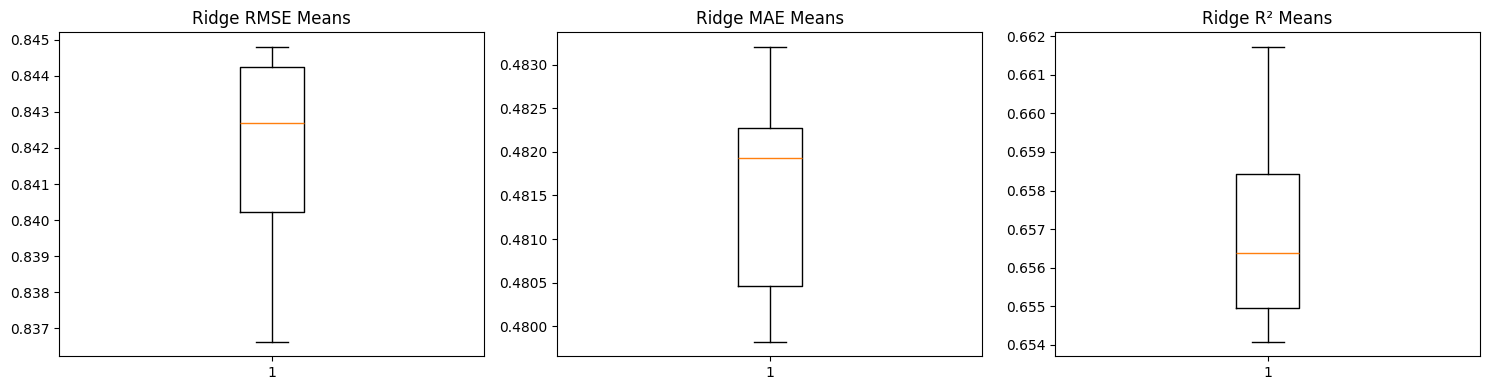

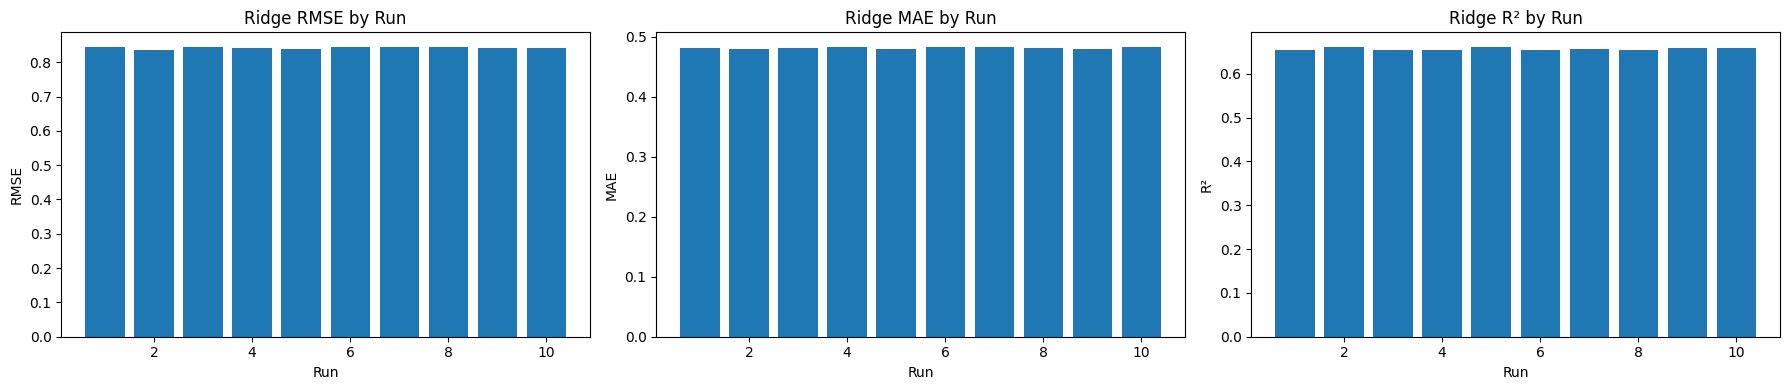


성능 지표 간 상관계수:
          MSE    RMSE     MAE      R2
MSE   1.0000  0.8842  0.6048 -0.8798
RMSE  0.8842  1.0000  0.7817 -0.9643
MAE   0.6048  0.7817  1.0000 -0.7318
R2   -0.8798 -0.9643 -0.7318  1.0000


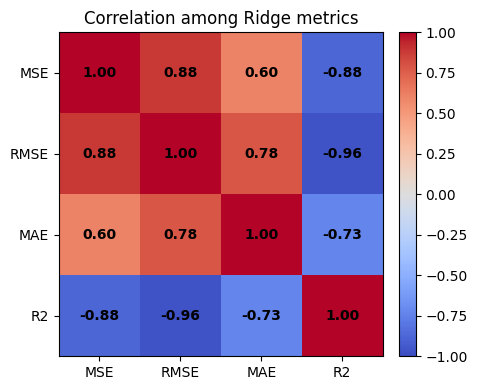


=== 3단계: Lasso 결과 종합 및 분석 ===

전체 10개 모델 성능 요약:
RMSE 평균: 0.8382 ± 0.0021
MAE  평균: 0.4744 ± 0.0007
R²   평균: 0.6600 ± 0.0021

최고 R² 모델: 2번째 (R²=0.6640)
최저 MSE 모델: 10번째 (MSE=0.7028, RMSE=0.8383)


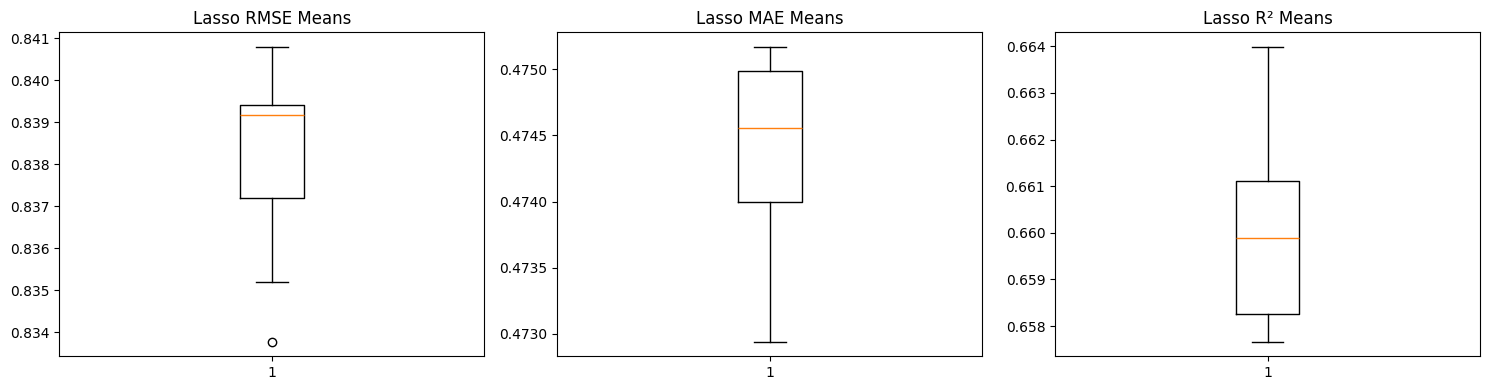

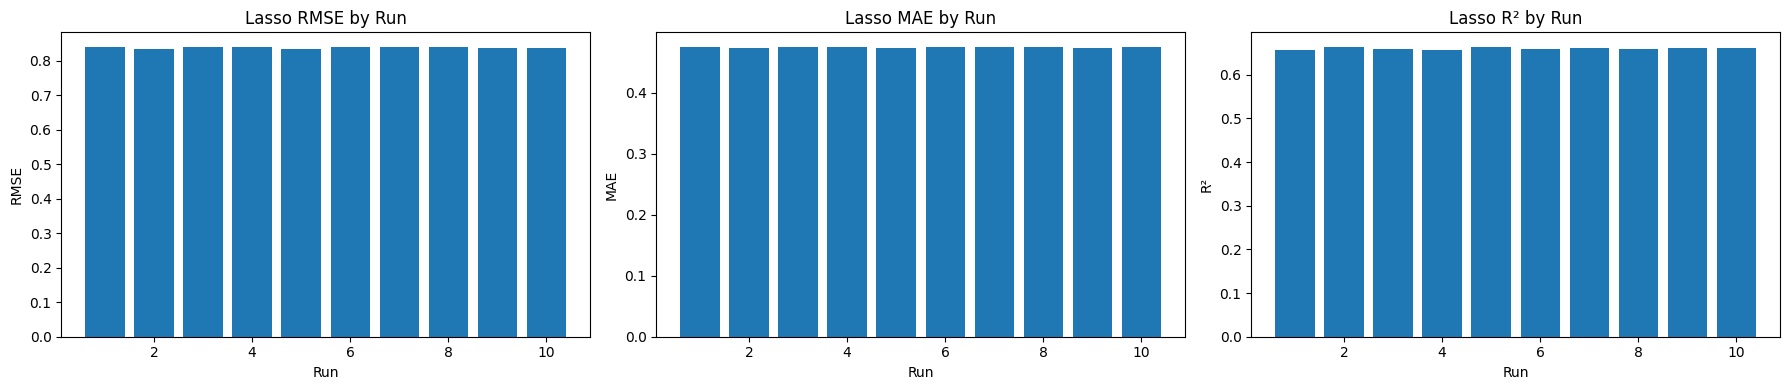


성능 지표 간 상관계수:
          MSE    RMSE     MAE      R2
MSE   1.0000  0.7482  0.5234 -0.8026
RMSE  0.7482  1.0000  0.8361 -0.9530
MAE   0.5234  0.8361  1.0000 -0.7820
R2   -0.8026 -0.9530 -0.7820  1.0000


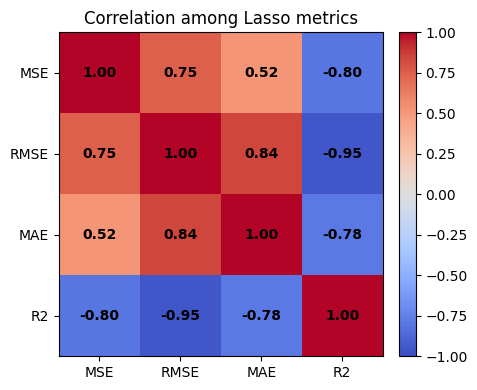


=== 3단계: OLS 결과 종합 및 분석 ===

전체 10개 모델 성능 요약:
RMSE 평균: 0.8418 ± 0.0028
MAE  평균: 0.4815 ± 0.0012
R²   평균: 0.6570 ± 0.0026

최고 R² 모델: 2번째 (R²=0.6615)
최저 MSE 모델: 5번째 (MSE=0.7064, RMSE=0.8405)


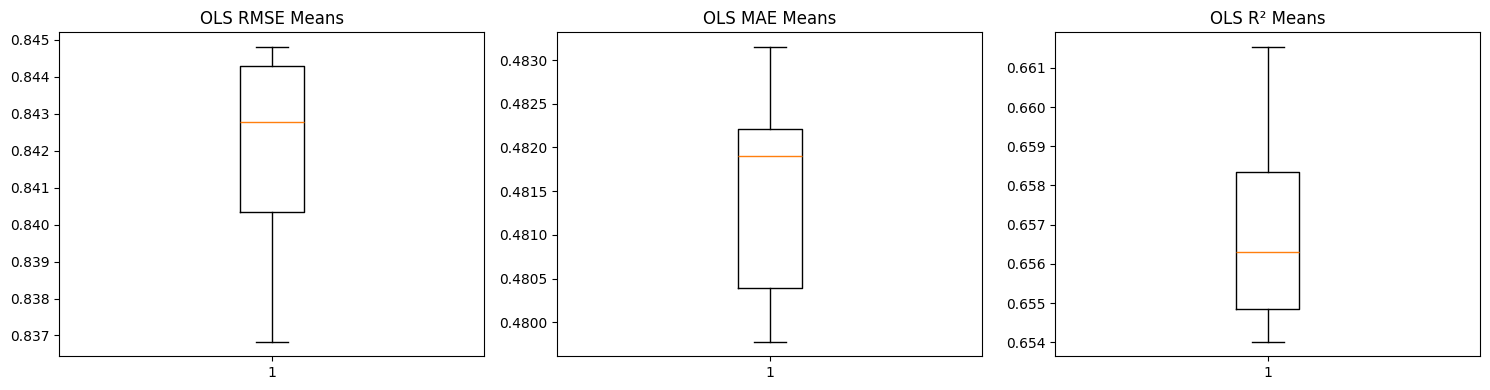

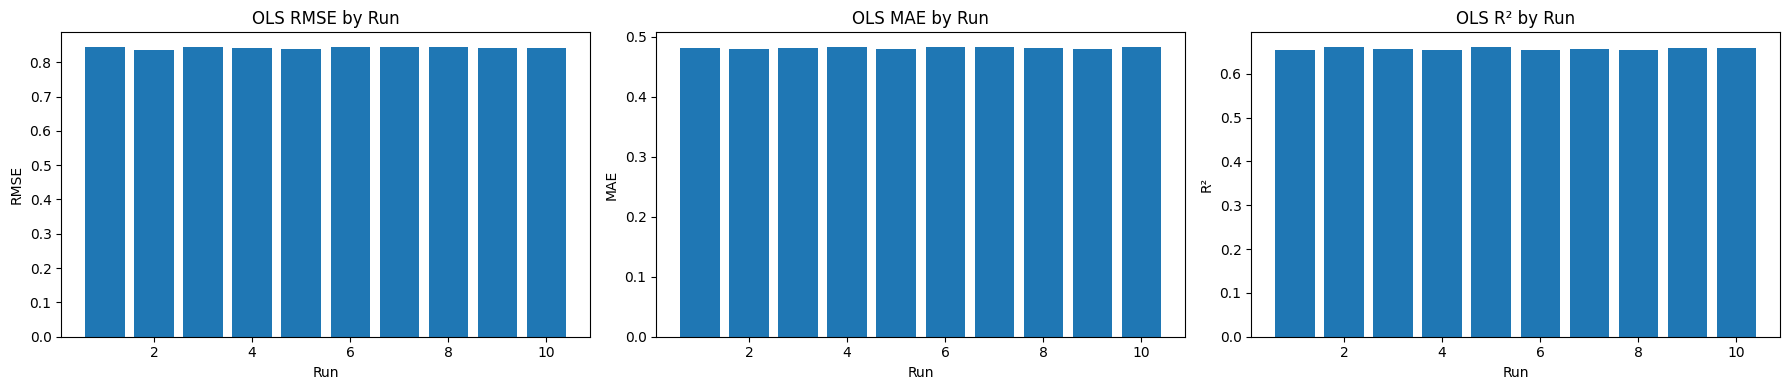


성능 지표 간 상관계수:
          MSE    RMSE     MAE      R2
MSE   1.0000  0.8840  0.6059 -0.8789
RMSE  0.8840  1.0000  0.7814 -0.9627
MAE   0.6059  0.7814  1.0000 -0.7268
R2   -0.8789 -0.9627 -0.7268  1.0000


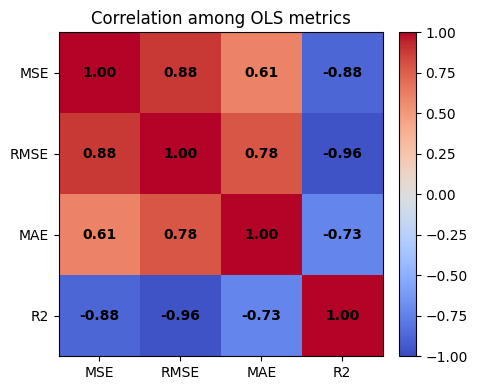

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_results(results, model_name="Linear Model"):
    """
    results: train_multiple_linear_models()가 반환한 리스트
             각 원소에 'rmse_mean', 'mae_mean', 'r2_mean', 'mse_mean' 키가 있어야 함
    model_name: 출력/그래프에 표시할 모델명 (예: 'OLS', 'Ridge', 'Lasso')
    """
    print(f"\n=== 3단계: {model_name} 결과 종합 및 분석 ===")
    rmse_means = [r['rmse_mean'] for r in results]
    mae_means  = [r['mae_mean']  for r in results]
    r2_means   = [r['r2_mean']   for r in results]
    mse_means  = [r['mse_mean']  for r in results]

    print(f"\n전체 {len(results)}개 모델 성능 요약:")
    print(f"RMSE 평균: {np.mean(rmse_means):.4f} ± {np.std(rmse_means):.4f}")
    print(f"MAE  평균: {np.mean(mae_means):.4f} ± {np.std(mae_means):.4f}")
    print(f"R²   평균: {np.mean(r2_means):.4f} ± {np.std(r2_means):.4f}")

    best_r2_idx  = int(np.argmax(r2_means))
    best_mse_idx = int(np.argmin(mse_means))
    print(f"\n최고 R² 모델: {best_r2_idx+1}번째 (R²={r2_means[best_r2_idx]:.4f})")
    print(f"최저 MSE 모델: {best_mse_idx+1}번째 (MSE={mse_means[best_mse_idx]:.4f}, RMSE={np.sqrt(mse_means[best_mse_idx]):.4f})")

    # --- Boxplot (분포)
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].boxplot(rmse_means); axes[0].set_title(f'{model_name} RMSE Means')
    axes[1].boxplot(mae_means);  axes[1].set_title(f'{model_name} MAE Means')
    axes[2].boxplot(r2_means);   axes[2].set_title(f'{model_name} R² Means')
    plt.tight_layout(); plt.show()

    # --- Bar plot (비교)
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    axes[0].bar(range(1, len(results)+1), rmse_means); axes[0].set_title(f'{model_name} RMSE by Run'); axes[0].set_xlabel('Run'); axes[0].set_ylabel('RMSE')
    axes[1].bar(range(1, len(results)+1), mae_means);  axes[1].set_title(f'{model_name} MAE by Run');  axes[1].set_xlabel('Run'); axes[1].set_ylabel('MAE')
    axes[2].bar(range(1, len(results)+1), r2_means);   axes[2].set_title(f'{model_name} R² by Run');   axes[2].set_xlabel('Run'); axes[2].set_ylabel('R²')
    plt.tight_layout(); plt.show()

    # --- 상관행렬
    corr_df = pd.DataFrame({
        'MSE': mse_means, 'RMSE': rmse_means, 'MAE': mae_means, 'R2': r2_means
    })
    corr = corr_df.corr()
    print("\n성능 지표 간 상관계수:\n", corr.round(4))

    plt.figure(figsize=(5,4))
    im = plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            plt.text(j, i, f'{corr.iloc[i, j]:.2f}', ha='center', va='center',
                     color='black', fontweight='bold')
    plt.title(f'Correlation among {model_name} metrics')
    plt.tight_layout(); plt.show()

    return best_r2_idx, best_mse_idx

# 사용 예시
best_r2_idx, best_mse_idx = analyze_results(results_ridge, model_name="Ridge")
best_r2_idx, best_mse_idx = analyze_results(results_lasso, model_name="Lasso")
best_r2_idx, best_mse_idx = analyze_results(results_ols,   model_name="OLS")


In [9]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# OS별 한글 폰트 설정
if platform.system() == 'Darwin':  # Mac
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # Windows
    plt.rc('font', family='Malgun Gothic')
else:  # Linux (예: Colab)
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지


=== OLS 특성 중요도 분석 ===

상위 10개 특성 중요도 (계수 절댓값 기준):


,feature,coef,abs_coef,sign
0,CMBS_EXPOBJ_LCLSF_NM_가연성가스,-1.336348,1.336348,-1
1,ARRIVAL_DELAY_MIN_LOG,0.831169,0.831169,1
2,CMBS_EXPOBJ_LCLSF_NM_위험물등,0.757173,0.757173,1
3,"CMBS_EXPOBJ_LCLSF_NM_자동차,철도차량,선박,항공기",-0.563560,0.563560,-1
4,IGTN_HTSRC_NM_화학적 발화열,-0.419234,0.419234,-1
5,CTPV_NM_서울특별시,-0.407421,0.407421,-1
6,"IGTN_HTSRC_NM_폭발물, 폭죽",0.340375,0.340375,1
7,CTPV_NM_전북특별자치도,0.312709,0.312709,1
8,CMBS_EXPOBJ_LCLSF_NM_쓰레기류,0.287849,0.287849,1
9,CMBS_EXPOBJ_LCLSF_NM_미상,0.263460,0.263460,1


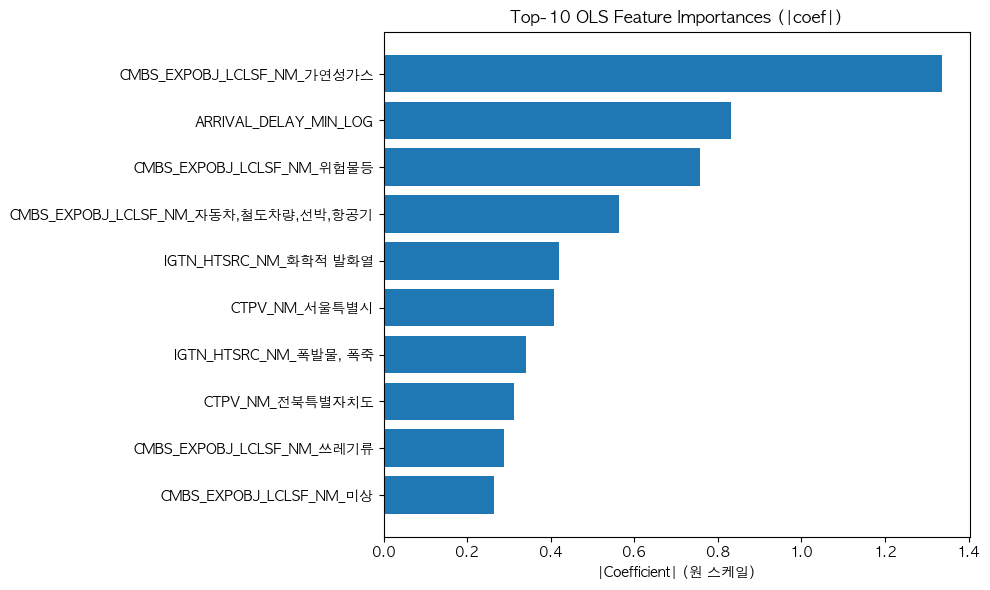


=== Ridge 특성 중요도 분석 ===

상위 10개 특성 중요도 (계수 절댓값 기준):


,feature,coef,abs_coef,sign
0,CMBS_EXPOBJ_LCLSF_NM_가연성가스,-1.507145,1.507145,-1
1,ARRIVAL_DELAY_MIN_LOG,0.828258,0.828258,1
2,"CMBS_EXPOBJ_LCLSF_NM_자동차,철도차량,선박,항공기",-0.744199,0.744199,-1
3,CMBS_EXPOBJ_LCLSF_NM_위험물등,0.572130,0.572130,1
4,CTPV_NM_서울특별시,-0.429776,0.429776,-1
5,"CMBS_EXPOBJ_LCLSF_NM_침구,직물류",-0.421538,0.421538,-1
6,"IGTN_HTSRC_NM_폭발물, 폭죽",0.411690,0.411690,1
7,IGTN_HTSRC_NM_화학적 발화열,-0.346342,0.346342,-1
8,CTPV_NM_전북특별자치도,0.289884,0.289884,1
9,IGTN_HTSRC_NM_자연적 발화열,0.224881,0.224881,1


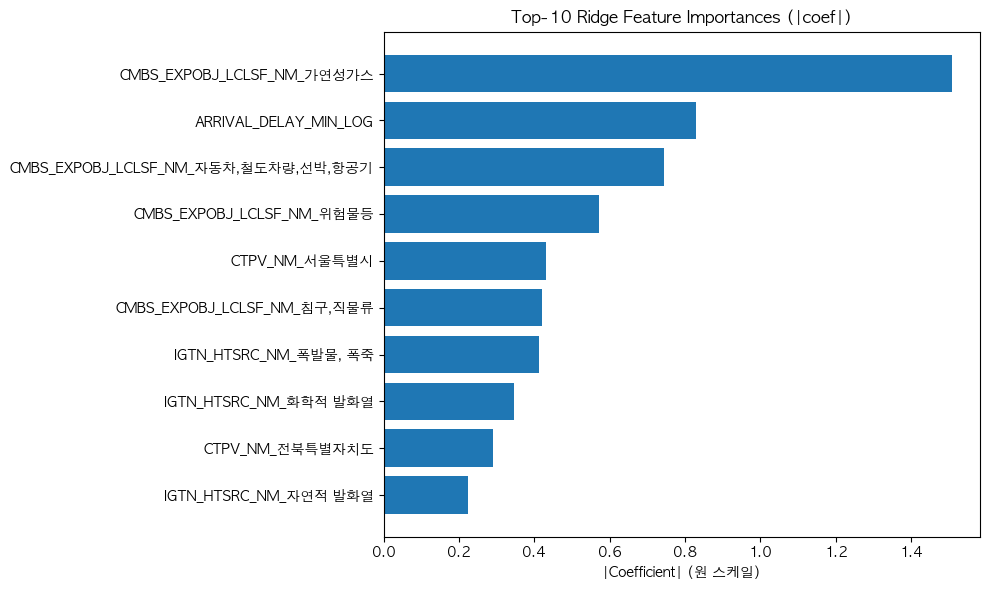


=== Lasso 특성 중요도 분석 ===

상위 10개 특성 중요도 (계수 절댓값 기준):


,feature,coef,abs_coef,sign
0,CMBS_EXPOBJ_LCLSF_NM_가연성가스,-1.128489,1.128489,-1
1,ARRIVAL_DELAY_MIN_LOG,0.831839,0.831839,1
2,CTPV_NM_서울특별시,-0.427056,0.427056,-1
3,"IGTN_HTSRC_NM_폭발물, 폭죽",0.291377,0.291377,1
4,CTPV_NM_대구광역시,-0.198347,0.198347,-1
5,CTPV_NM_전북특별자치도,0.196980,0.196980,1
6,CTPV_NM_울산광역시,-0.176866,0.176866,-1
7,IGTN_HTSRC_NM_화학적 발화열,-0.175325,0.175325,-1
8,CTPV_NM_경기도,-0.163473,0.163473,-1
9,CTPV_NM_인천광역시,-0.149311,0.149311,-1


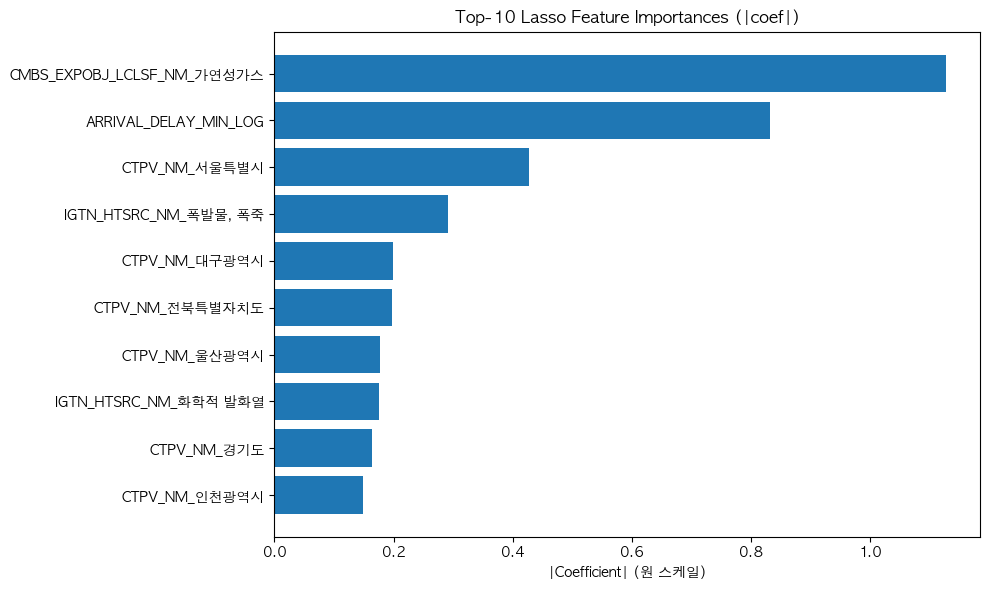

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso

def _extract_linear_and_scaler(model):
    """
    모델이 Pipeline(StandardScaler -> LinearModel)인지, 단일 선형모델인지 감지 후
    (linear_model, scaler_or_None)를 반환
    """
    if isinstance(model, Pipeline):
        # 마지막 스텝이 선형모델인지 확인
        last_name, last_est = model.steps[-1]
        if not isinstance(last_est, (LinearRegression, Ridge, Lasso)):
            raise TypeError("파이프라인의 마지막 스텝이 LinearRegression/Ridge/Lasso가 아닙니다.")
        # StandardScaler가 있는지 찾기 (첫 스텝 가정)
        scaler = None
        for name, est in model.steps:
            if hasattr(est, "mean_") and hasattr(est, "scale_"):
                scaler = est
        return last_est, scaler
    else:
        if not isinstance(model, (LinearRegression, Ridge, Lasso)):
            raise TypeError("지원되지 않는 모델 타입입니다. LinearRegression/Ridge/Lasso 또는 그 파이프라인만 지원합니다.")
        return model, None

def _coef_to_original_scale(coef_std, intercept_std, scaler):
    """
    표준화된 X에서 학습한 계수(coef_std, intercept_std)를
    원본 X 스케일로 변환.
      - w_orig = w_std / scale_
      - b_orig = b_std - sum(mean_/scale_ * w_std)
    """
    if scaler is None:
        return coef_std, intercept_std
    scale = scaler.scale_
    mean  = scaler.mean_
    w_orig = coef_std / scale
    b_orig = intercept_std - np.sum((mean / scale) * coef_std)
    return w_orig, b_orig

def linear_feature_importance(best_model, X, top_k=10, model_name="Linear Model"):
    """
    OLS/Ridge/Lasso 모델의 '특성 중요도'를 계수 절댓값 기준으로 계산/시각화.
    - best_model: LinearRegression / Ridge / Lasso 또는 Pipeline(StandardScaler, ...)
    - X: 학습(또는 현재) 특성 DataFrame (컬럼명이 중요)
    - top_k: 상위 표시 개수
    - model_name: 출력용 라벨
    """
    print(f"\n=== {model_name} 특성 중요도 분석 ===")

    assert isinstance(X, pd.DataFrame), "X는 컬럼명이 있는 pandas DataFrame이어야 합니다."
    feature_cols = list(X.columns)

    # 1) 모델/스케일러 추출
    lin, scaler = _extract_linear_and_scaler(best_model)

    # 2) 계수 추출 (표준화 공간에서의 coef_, intercept_)
    coef_std = lin.coef_.ravel()
    intercept_std = lin.intercept_

    # 3) 원본 스케일로 복원
    coef_orig, intercept_orig = _coef_to_original_scale(coef_std, intercept_std, scaler)

    # 4) 중요도 DF (절댓값 기준 내림차순)
    fi = pd.DataFrame({
        "feature": feature_cols,
        "coef": coef_orig,
        "abs_coef": np.abs(coef_orig),
        "sign": np.sign(coef_orig).astype(int)
    }).sort_values("abs_coef", ascending=False).reset_index(drop=True)

    print("\n상위 {}개 특성 중요도 (계수 절댓값 기준):".format(top_k))
    display(fi.head(top_k))

    # 5) 시각화
    plt.figure(figsize=(10, 6))
    top = fi.head(top_k).iloc[::-1]  # 위에서 아래로 큰 항목이 보이게 역순
    plt.barh(range(len(top)), top["abs_coef"])
    plt.yticks(range(len(top)), top["feature"])
    plt.xlabel("|Coefficient| (원 스케일)")
    plt.title(f"Top-{top_k} {model_name} Feature Importances (|coef|)")
    plt.tight_layout()
    plt.show()

    return fi, intercept_orig

# =========================
# 사용 예시
# =========================
# (1) OLS 단독 학습 후:
ols = LinearRegression().fit(X, y)
fi_ols, b0_ols = linear_feature_importance(ols, X, top_k=10, model_name="OLS")

# (2) Ridge 파이프라인(표준화 포함) 학습 후:
from sklearn.pipeline import make_pipeline
ridge_pipe = make_pipeline(StandardScaler(with_mean=True), Ridge(alpha=10.0))
ridge_pipe.fit(X, y)
fi_ridge, b0_ridge = linear_feature_importance(ridge_pipe, X, top_k=10, model_name="Ridge")

# (3) Lasso 파이프라인(표준화 포함) 학습 후:
lasso_pipe = make_pipeline(StandardScaler(with_mean=True), Lasso(alpha=0.01, max_iter=20000))
lasso_pipe.fit(X, y)
fi_lasso, b0_lasso = linear_feature_importance(lasso_pipe, X, top_k=10, model_name="Lasso")



=== OLS : 5-Fold CV (로그 스케일 기준) ===
[Fold 1] RMSE=0.8098 | MAE=0.4768 | R²=0.6775
[Fold 2] RMSE=0.8900 | MAE=0.4929 | R²=0.5936
[Fold 3] RMSE=0.7965 | MAE=0.4803 | R²=0.6919
[Fold 4] RMSE=0.8989 | MAE=0.4878 | R²=0.6675
[Fold 5] RMSE=0.8283 | MAE=0.4715 | R²=0.6422

[OLS] === CV 평균(로그 스케일) ===
RMSE(mean±std): 0.8447 ± 0.0420
MAE (mean±std): 0.4819 ± 0.0077
R²  (mean±std): 0.6545 ± 0.0345

[OLS] === 실제 종속변수 통계 (표시 단위 → 분) ===
평균: 112.03 분  |  (1.87 시간, ~1h 52m)
중앙값: 59.22 분  |  (0.99 시간, ~0h 59m)
표준편차: 184.58 분  |  (3.08 시간, ~3h 4m)

[OLS] === 예측 통계 (표시 단위 → 분) ===
예측 평균: 121.67 분  |  (2.03 시간, ~2h 1m)
예측 중앙값: 53.95 분  |  (0.90 시간, ~0h 53m)
평균 차이(예측-실제): 9.64 분  |  (0.16 시간, ~0h 9m)
중앙값 차이(예측-실제): -5.27 분  |  (-0.09 시간, ~-1h 54m)

[OLS] === 원 단위 오차 지표 (참고) ===
RMSE: 287.95 분  |  (4.80 시간, ~4h 47m)
MAE: 67.94 분  |  (1.13 시간, ~1h 7m)
R²  : -1.4335  (역변환 후 R²는 참고용)

=== Ridge : 5-Fold CV (로그 스케일 기준) ===
[Fold 1] RMSE=0.8099 | MAE=0.4769 | R²=0.6775
[Fold 2] RMSE=0.8890 | MAE=0.4925 | R²=0

,model,log_RMSE_mean,log_RMSE_std,log_MAE_mean,log_MAE_std,log_R2_mean,log_R2_std,orig_RMSE,orig_MAE,orig_R2
2,Lasso,0.840271,0.046430,0.472305,0.010570,0.658074,0.037058,16626.351552,3922.776473,-1.253746
1,Ridge,0.844574,0.041861,0.481839,0.007541,0.654673,0.034132,17025.402789,4047.094447,-1.363230
0,OLS,0.844694,0.041964,0.481857,0.007665,0.654546,0.034505,17276.784544,4076.432364,-1.433531


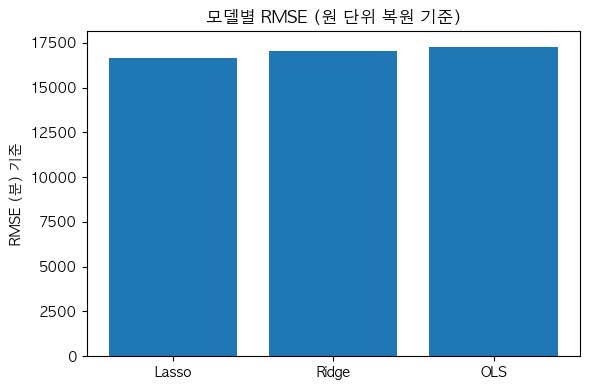

In [12]:
# === OLS / Ridge / Lasso 3개 한 번에 비교 ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# -----------------------
# 설정
# -----------------------
TARGET_IS_LOG = True       # 타깃이 log1p 변환된 컬럼이면 True (expm1로 역변환)
TIME_UNIT     = "min"      # 출력 단위: 'sec' | 'min' | 'hour'
SHOW_BOTH     = True
N_SPLITS      = 5
RANDOM_STATE  = 42

# 튜닝 완료된 alpha 값 넣으세요
RIDGE_ALPHA = float(np.float64(10.0))
LASSO_ALPHA = float(np.float64(0.016681005372000592))

assert 'X' in globals() and 'y' in globals(), "먼저 X, y를 준비하세요."
X_np = np.asarray(X)
y_np = np.asarray(y, dtype=float)

# -----------------------
# 표시/단위 헬퍼
# -----------------------
def to_unit(v_sec, unit="sec"):
    if unit == "min":  return v_sec / 60.0
    if unit == "hour": return v_sec / 3600.0
    return v_sec

def unit_label(unit):
    return {"sec":"초", "min":"분", "hour":"시간"}[unit]

def hhmm(v_sec):
    v_sec = float(v_sec)
    h = int(v_sec // 3600)
    m = int((v_sec % 3600) // 60)
    return f"{h}h {m}m"

def show_with_both(name, v_sec):
    main_val = to_unit(v_sec, TIME_UNIT)
    s = f"{name}: {main_val:,.2f} {unit_label(TIME_UNIT)}"
    if SHOW_BOTH:
        other_unit = {"sec":"min", "min":"hour", "hour":"min"}[TIME_UNIT]
        other_val  = to_unit(v_sec, other_unit)
        s += f"  |  ({other_val:,.2f} {unit_label(other_unit)}, ~{hhmm(v_sec)})"
    return s

# -----------------------
# 모델 빌더
# -----------------------
def build_estimator(name):
    if name == "OLS":
        return LinearRegression()
    if name == "Ridge":
        return make_pipeline(StandardScaler(with_mean=True), Ridge(alpha=RIDGE_ALPHA))
    if name == "Lasso":
        return make_pipeline(StandardScaler(with_mean=True), Lasso(alpha=LASSO_ALPHA, max_iter=20000))
    raise ValueError("name은 'OLS' | 'Ridge' | 'Lasso' 중 하나여야 합니다.")

# -----------------------
# 단일 모델 평가 (기존 XGBoost 코드 흐름 그대로)
# -----------------------
def evaluate_one(name):
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

    y_true_list_log, y_pred_list_log = [], []
    rmse_list_log, mae_list_log, r2_list_log = [], [], []

    print(f"\n=== {name} : {N_SPLITS}-Fold CV (로그 스케일 기준) ===")
    for fold_idx, (tr, va) in enumerate(kf.split(X_np), start=1):
        X_tr, X_va = X_np[tr], X_np[va]
        y_tr, y_va = y_np[tr], y_np[va]

        model = build_estimator(name)
        model.fit(X_tr, y_tr)
        y_va_pred = model.predict(X_va)

        rmse_log = np.sqrt(mean_squared_error(y_va, y_va_pred))
        mae_log  = mean_absolute_error(y_va, y_va_pred)
        r2_log   = r2_score(y_va, y_va_pred)

        rmse_list_log.append(rmse_log)
        mae_list_log.append(mae_log)
        r2_list_log.append(r2_log)

        y_true_list_log.append(y_va)
        y_pred_list_log.append(y_va_pred)

        print(f"[Fold {fold_idx}] RMSE={rmse_log:.4f} | MAE={mae_log:.4f} | R²={r2_log:.4f}")

    # fold 전체 합치기 (로그 스케일)
    y_all_true_log = np.concatenate(y_true_list_log)
    y_all_pred_log = np.concatenate(y_pred_list_log)

    # 원 단위(초) 복원
    if TARGET_IS_LOG:
        y_all_true_sec = np.expm1(y_all_true_log)
        y_all_pred_sec = np.expm1(y_all_pred_log)
    else:
        y_all_true_sec = y_all_true_log
        y_all_pred_sec = y_all_pred_log

    # 통계/지표 (원 단위)
    mean_true    = float(np.mean(y_all_true_sec))
    median_true  = float(np.median(y_all_true_sec))
    std_true     = float(np.std(y_all_true_sec))

    mean_pred    = float(np.mean(y_all_pred_sec))
    median_pred  = float(np.median(y_all_pred_sec))

    rmse_orig = float(np.sqrt(mean_squared_error(y_all_true_sec, y_all_pred_sec)))
    mae_orig  = float(mean_absolute_error(y_all_true_sec, y_all_pred_sec))
    r2_orig   = float(r2_score(y_all_true_sec, y_all_pred_sec))  # 참고용

    print(f"\n[{name}] === CV 평균(로그 스케일) ===")
    print(f"RMSE(mean±std): {np.mean(rmse_list_log):.4f} ± {np.std(rmse_list_log):.4f}")
    print(f"MAE (mean±std): {np.mean(mae_list_log):.4f} ± {np.std(mae_list_log):.4f}")
    print(f"R²  (mean±std): {np.mean(r2_list_log):.4f} ± {np.std(r2_list_log):.4f}")

    print(f"\n[{name}] === 실제 종속변수 통계 (표시 단위 → {unit_label(TIME_UNIT)}) ===")
    print(show_with_both("평균",     mean_true))
    print(show_with_both("중앙값",   median_true))
    print(show_with_both("표준편차", std_true))

    print(f"\n[{name}] === 예측 통계 (표시 단위 → {unit_label(TIME_UNIT)}) ===")
    print(show_with_both("예측 평균",    mean_pred))
    print(show_with_both("예측 중앙값",  median_pred))
    print(show_with_both("평균 차이(예측-실제)",   mean_pred - mean_true))
    print(show_with_both("중앙값 차이(예측-실제)", median_pred - median_true))

    print(f"\n[{name}] === 원 단위 오차 지표 (참고) ===")
    print(show_with_both("RMSE", rmse_orig))
    print(show_with_both("MAE",  mae_orig))
    print(f"R²  : {r2_orig:.4f}  (역변환 후 R²는 참고용)")

    # 요약 반환
    summary = {
        "model": name,
        "log_RMSE_mean": np.mean(rmse_list_log), "log_RMSE_std": np.std(rmse_list_log),
        "log_MAE_mean":  np.mean(mae_list_log),  "log_MAE_std":  np.std(mae_list_log),
        "log_R2_mean":   np.mean(r2_list_log),   "log_R2_std":   np.std(r2_list_log),
        "orig_RMSE": rmse_orig, "orig_MAE": mae_orig, "orig_R2": r2_orig
    }
    return summary

# -----------------------
# 3개 모델 한 번에 실행
# -----------------------
def run_all_three():
    summaries = []
    for name in ["OLS", "Ridge", "Lasso"]:
        summaries.append(evaluate_one(name))
    df = pd.DataFrame(summaries)

    # 보기 좋게 정렬
    cols = ["model",
            "log_RMSE_mean", "log_RMSE_std",
            "log_MAE_mean",  "log_MAE_std",
            "log_R2_mean",   "log_R2_std",
            "orig_RMSE", "orig_MAE", "orig_R2"]
    df = df[cols].sort_values("orig_RMSE")

    print("\n=== 모델별 요약 표 ===")
    display(df)

    # 간단 비교 그래프 (원 단위 RMSE)
    plt.figure(figsize=(6,4))
    plt.bar(df["model"], df["orig_RMSE"])
    plt.ylabel(f"RMSE ({unit_label(TIME_UNIT)}) 기준")  # 실제 단위는 초→표시단위 환산 안함. 필요시 to_unit()로 변환 가능
    plt.title("모델별 RMSE (원 단위 복원 기준)")
    plt.tight_layout()
    plt.show()

    return df

# =============================
# 사용 예시
# =============================
df_summary = run_all_three()
